In [4]:
#pip install adjustText

In [7]:
####################################################################################
# this code defines function to create edges for specific drainage basin
# edgesは2都市間のupstreamとdownstreamの関係をすべて保存したリスト
####################################################################################

import numpy as np
import json
from collections import defaultdict
from collections import defaultdict, deque

##########################################################
# kinshana river basin
# hydrabad=citynum(40)
# 19 cities
riv_num = 64
uid_str = '64.0'
distance = 100
##########################################################

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
basin_cities_path = f'{h08dir}/global_city/dat/riv_num_/basin_to_cities_{distance}km.json'

with open(basin_cities_path, 'r') as json_file:
    new_basin_to_cities = json.load(json_file)
    
def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped

def is_valid_edge(city1, city2, coords_dict):
    for coord, city_list in coords_dict.items():
        if len(city_list) > 1:
            if city1 in city_list and city2 in city_list:
                if city1 > city2:
                    continue
                else:
                    city1, city2 = None, None
                    
    if city1 and city2:
        return True
    else:
        return False

def updown(new_basin_to_cities, uid_str='3.0', distance=100, riv_num=3):
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    
    city_list = new_basin_to_cities[uid_str]
    city_list = [int(i) for i in city_list]
    
    # rivnextlonlat 
    rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
    rivnxl_gl5 = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
    riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_gl5, 0, 0)
    
    # remove overlap
    overlap_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/overlap_hidden_only.txt'
    with open(overlap_path, 'r') as f:
        numbers = [int(line.strip()) for line in f]
    city_list_removed = [num for num in city_list if num not in numbers]
    city_list_removed = [int(i) for i in city_list_removed]
    
    # rivout
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout_gl5 = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    
    # coord of purficication
    coords_a = []
    #special_lst = [2, 1089, 1288, 1620]
    for city_num in city_list_removed:
    #for city_num in special_lst:
        # rivnum
        rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
        rivnum_gl5 = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)

        # prf
        prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)

        # int
        int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
        
        # 1. prfのみが対象流域内(uid)
        # 2. intのみが対象流域内(uid)
        # 3. prfとintどちらもが対象領域内(uid)
        uid_int = int(riv_num)
        prf_coord = np.where((prf == 1) & (rivnum_gl5 == uid_int))
        int_coord = np.where((intake == 1) & (rivnum_gl5 == uid_int))
        
        if prf_coord[0].size != 0 and int_coord[0].size != 0:
            
            prf_runout = rivout_gl5[prf_coord][0] * 60 * 60 * 24 * 365 / (1000)
            int_runout = rivout_gl5[int_coord][0] * 60 * 60 * 24 * 365 / (1000)
            
            if prf_runout > int_runout:
                larger_coord = prf_coord
            else:
                larger_coord = int_coord
                
        elif prf_coord[0].size != 0 and int_coord[0].size == 0:
            larger_coord = prf_coord
            
        elif prf_coord[0].size == 0 and int_coord[0].size != 0:
            larger_coord = int_coord
            
        else:
            larger_coord = prf_coord
            continue
            
        coords_a.append([larger_coord, city_num])
        
####################################################################################
# 1. 同流域内で取水点がかぶっている都市を取水点ごとにリストにする
####################################################################################

    # 同じ座標に対して city_num のリストを作成するための辞書
    coords_dict = defaultdict(list)

    # coords_a の要素をループして座標をキーに city_num をリストに追加
    for coord, city_num in coords_a:
        coord_tuple = (tuple(coord[0]), tuple(coord[1]))
        coords_dict[coord_tuple].append(city_num)

####################################################################################
# check what's happening in 1089, 1288, 1620
####################################################################################
        
    # down
    edges = []
    riv_path_array = np.zeros((2160, 4320))
    
    # city_num loop 
    for idx in range(len(coords_a)):
        
        cityup = coords_a[idx][1]
        
        visited_coords = set()
        
        # coords_a[idx][0] = (array([732]), array([3086]))
        riv_path_array[coords_a[idx][0][0][0], coords_a[idx][0][1][0]] = idx

        # coordinates of prf and intake
        coords_b = coords_a.copy()
        coords_b.pop(idx) 
        
        if len(coords_a) > 0:
            target_coord = (coords_a[idx][0][0][0], coords_a[idx][0][1][0])
            
            while True:
                if target_coord in visited_coords:
                    break
                visited_coords.add(target_coord)
                
                next_coord = riv_nxlonlat_cropped[target_coord[0], target_coord[1]]
                if next_coord.size == 0 or next_coord.shape != (2,):
                    break
                
                next_coord = (next_coord[0], next_coord[1])
                riv_path_array[next_coord[0], next_coord[1]] = idx
                target_coord = next_coord

        for coord in coords_b:
            citydwn = coord[1]
            
            if coord[0][0].size == 0:
                continue
            else:
                standard_coord = (coord[0][0][0], coord[0][1][0])
                if standard_coord in visited_coords:
                    edge_flag = is_valid_edge(cityup, citydwn, coords_dict)
                    if edge_flag:
                        edges.append((cityup, citydwn))
                    else:
                        continue
                else:
                    continue
                    
    # edgesは2都市間のupstreamとdownstreamの関係をすべて保存したリスト
    return edges, riv_path_array, coords_a, city_list_removed
    
#############################################################
# トポロジカルソート
# edgesが必要
#############################################################

def topological_sort(edges):
    # 都市間の流れを構築
    graph = defaultdict(list)
    indegree = defaultdict(int)
    nodes = set()
    
    for upstream, downstream in edges:
        graph[upstream].append(downstream)
        indegree[downstream] += 1
        nodes.add(upstream)
        nodes.add(downstream)
    
    # トポロジカルソート
    queue = deque([node for node in nodes if indegree[node] == 0])
    sorted_order = []
    
    while queue:
        node = queue.popleft()
        sorted_order.append(node)
        
        for neighbor in graph[node]:
            indegree[neighbor] -= 1
            if indegree[neighbor] == 0:
                queue.append(neighbor)
    
    return sorted_order

#edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str=uid_str, riv_num=riv_num)
#sorted_order = topological_sort(edges)

In [8]:
import os
import pandas as pd

def get_pop(sorted_order):
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_{distance}km_abandon.txt'
    df_new = pd.read_csv(updown_path, delimiter='|', header=None)
    df_new.columns = df_new.iloc[0]
    df_new = df_new[1:].reset_index(drop=True)
    df_new = df_new.infer_objects()
    
    # population
    population = [df_new.loc[df_new['index'] == f'{city_num}', 'pop'].values[0] for city_num in sorted_order]
    population = [int(float(i)) for i in population]
    return population

def get_ava(riv_num, sorted_order):
    availability = []
    
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
    int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'
    
    rivnum_gl5 = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320)
    rivout_gl5 = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    
    for city_num in sorted_order:
        
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        
        if not os.path.exists(prf_path):
            print(f'{city_num} is invalid prf')
    
        else:
            error_flag = False
            prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
            intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
            
            int_rivnum = rivnum_gl5[intake==1]
            
            if int_rivnum.size != 0:
                
                prf_coord = np.where((prf == 1) & (rivnum_gl5 == riv_num))
                int_coord = np.where((intake==1) & (rivnum_gl5 == riv_num))
                
                if prf_coord[0].size != 0 and int_coord[0].size != 0:
                    
                    prf_runout = rivout_gl5[prf_coord][0] * 60 * 60 * 24 * 365 / (1000)
                    int_runout = rivout_gl5[int_coord][0] * 60 * 60 * 24 * 365 / (1000)
                    
                    if prf_runout > int_runout:
                        source_coord = prf_coord
                    else:
                        source_coord = int_coord
                        
                elif prf_coord[0].size != 0 and int_coord[0].size == 0:
                    source_coord = prf_coord
                    
                elif prf_coord[0].size == 0 and int_coord[0].size != 0:
                    source_coord = int_coord
                    
                else:
                    error_flag = True
                    print(f'{city_num} Error no prf no int')

            if error_flag:
                discharge = 0
                error_flag = False
            else:
                discharge = rivout_gl5[source_coord][0] * 60 * 60 * 24 * 365 / (1000)
    
        availability.append(int(float(discharge)))
        
    return availability

"""
pop = get_pop(sorted_order)
ava = get_ava(riv_num=3)
"""

'\npop = get_pop(sorted_order)\nava = get_ava(riv_num=3)\n'

In [9]:
#---------------------------------------------------------------------------------------------------------------
#   (path_coord) 主河道の各経路が座標として保存されている
#---------------------------------------------------------------------------------------------------------------

def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped
    
def get_rivpath(riv_num, sorted_order, upperindex, lowerindex, leftindex, rightindex):
    
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    
    prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
    int_dir = f'{h08dir}/global_city/dat/cty_int_/100km_samebasin'
    
    # rivnxl in xy coord
    rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
    rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
    rivnxl_cropped = rivnxl[upperindex:lowerindex, leftindex:rightindex]
    riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_cropped, upperindex, leftindex)

    # rivara
    rivara_path = f'{h08dir}/global_city/dat/riv_ara_/rivara.CAMA.gl5'
    rivara = np.fromfile(rivara_path, 'float32').reshape(2160, 4320)
    rivara_cropped = rivara[upperindex:lowerindex, leftindex:rightindex]
    
    # rivnum
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum = rivnum.astype(int)
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]

    # rivout
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex]

    # city_numをkeyにしてprfまたはintの下流になるrivpathを保存
    rivpath_dict = {}
    
    for city_num in sorted_order:
        
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        
        if not os.path.exists(prf_path):
            print(f'{city_num} is invalid prf')
    
        else:
            prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
            prf_cropped = prf[upperindex:lowerindex, leftindex:rightindex]
            intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
            intake_cropped = intake[upperindex:lowerindex, leftindex:rightindex]
            
            int_rivnum = rivnum_cropped[intake_cropped==1]
            
            if int_rivnum.size != 0:
                
                prf_coord = np.where((prf_cropped == 1) & (rivnum_cropped == int(riv_num)))
                int_coord = np.where((intake_cropped == 1) & (rivnum_cropped == riv_num))
                
                if prf_coord[0].size != 0 and int_coord[0].size != 0:
                    
                    prf_runout = rivout_cropped[prf_coord][0] * 60 * 60 * 24 * 365 / (1000)
                    int_runout = rivout_cropped[int_coord][0] * 60 * 60 * 24 * 365 / (1000)
                    
                    if prf_runout > int_runout:
                        source_coord = prf_coord
                    else:
                        source_coord = int_coord
                        
                elif prf_coord[0].size != 0 and int_coord[0].size == 0:
                    source_coord = prf_coord
                    
                elif prf_coord[0].size == 0 and int_coord[0].size != 0:
                    source_coord = int_coord
                    
                else:
                    print('Error no prf no int')
    
        target_coord = (source_coord[0][0], source_coord[1][0]) 
        path_coords = [target_coord]
        visited_coords = set()
        
        while True:
            if target_coord in visited_coords:
                break
            visited_coords.add(target_coord)
            target_row, target_col = target_coord
            next_coord = riv_nxlonlat_cropped[target_row, target_col]
            if next_coord.size == 0 or next_coord.shape != (2,):
                break
            target_coord = (next_coord[0], next_coord[1])
            path_coords.append(target_coord)

        rivpath_dict[city_num] = path_coords
    
    return rivpath_dict

"""
left, right, bottom, top = 25, 70, 25, 70
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
sorted_order = topological_sort(edges)
path_dict = get_rivpath(riv_num, sorted_order, upperindex, lowerindex, leftindex, rightindex)
"""

'\nleft, right, bottom, top = 25, 70, 25, 70\nupperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)\nsorted_order = topological_sort(edges)\npath_dict = get_rivpath(riv_num, sorted_order, upperindex, lowerindex, leftindex, rightindex)\n'

In [52]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# y軸を1e9のオーダーで表示するフォーマッターを定義
def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fB' % (x * 1e-9)

# y軸を100ミリオンのオーダーで表示するフォーマッターを定義
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

def bar_line(uid_str, riv_num):
    # load
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    basin_cities_path = f'{h08dir}/global_city/dat/riv_num_/basin_to_cities_{distance}km.json'
    with open(basin_cities_path, 'r') as json_file:
        new_basin_to_cities = json.load(json_file)

    # xaxis
    edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str=uid_str, riv_num=riv_num)
    sorted_order = topological_sort(edges)
    xaxis = [f'{i}' for i in sorted_order]

    # pop ava
    population = get_pop(sorted_order)
    availability = get_ava(riv_num, sorted_order)
    
    availability_formatter = FuncFormatter(billions)
    population_formatter = FuncFormatter(millions)
    
    # プロットの作成
    fig, ax1 = plt.subplots(figsize=(10, 5))
    
    # availabilityの折れ線グラフ
    ax1.plot(xaxis, availability, color='#57acff', label='Availability')
    ax1.set_ylabel('Availability (B)', color='#57acff', fontsize=20)
    ax1.yaxis.set_major_formatter(availability_formatter)
    ax1.set_ylim(0, 10e9)
    ax1.tick_params(axis='both', labelsize=10)
    
    # x軸ラベルを90度回転
    ax1.set_xticks(range(len(xaxis)))
    ax1.set_xticklabels(xaxis, rotation=90)
    
    # ツイン軸の作成
    ax2 = ax1.twinx()
    
    # populationの棒グラフ
    ax2.bar(xaxis, population, alpha=0.5, color='orange', label='Population')
    ax2.set_ylabel('Population (100M)', color='orange', fontsize=20)
    ax2.yaxis.set_major_formatter(population_formatter)
    ax2.set_ylim(0, 10e6)
    ax2.tick_params(axis='both', labelsize=10)
    
    # グラフの表示
    fig.tight_layout()
    plt.show()

In [11]:
#############################################################
# 都市の位置と河川の配置と流域範囲を示す地図をプロットしたい
#############################################################

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors
from adjustText import adjust_text

def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

def main_plot(left, right, bottom, top, riv_num=3, uid_str='3.0'):
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # riv
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
    rivnum_masked = np.ma.masked_where(rivnum_cropped != riv_num, rivnum_cropped)
    
    # discharge
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000

    # lonlat
    lonlat_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat.npy'
    citylonlat = np.load(lonlat_path)

    nums = citylonlat[:, 0]
    lons = citylonlat[:, 1]
    lats = citylonlat[:, 2]

    # sort
    edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str=uid_str, riv_num=riv_num)
    sorted_order = topological_sort(edges)
    sorted_index = []
    for cnm in sorted_order:
        idx = np.where(np.array(nums) == cnm)[0]
        sorted_index.append(idx)

    target_lons = lons[sorted_index]
    target_lats = lats[sorted_index]
    
    # rivnxl
    path_dict = get_rivpath(riv_num, sorted_order, upperindex, lowerindex, leftindex, rightindex)

    # population
    updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon.txt'
    df_new = pd.read_csv(updown_path, delimiter='|', header=None)
    df_new.columns = df_new.iloc[0]
    df_new = df_new[1:].reset_index(drop=True)
    df_new = df_new.infer_objects()
    
    population = [df_new.loc[df_new['index'] == f'{city_num}', 'pop'].values[0] for city_num in sorted_order]
    population = [int(float(i)) for i in population]
    pop_size = [35 if i > 1e6 else 5 for i in population]

    mpcy_int = [df_new.loc[df_new['index'] == f'{city_num}', 'mpcy_int'].values[0] for city_num in sorted_order]
    target_mpcy = [int(float(i)) for i in mpcy_int]

    # cmap
    bounds = [0, 1000]
    cmap = mcolors.ListedColormap(['red', 'blue'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    rivnum_cmap = mcolors.ListedColormap(['#ffe500'])
    river_cmap = mcolors.ListedColormap(['#57acff'])

    # draw
    plt.rcParams["font.size"] = 50
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], ccrs.PlateCarree())

    # rivnxl
    width = 1
    
    for city_num in sorted_order:
        path_coords = path_dict[city_num]
        
        #2つずつのペアに変換
        path_coords_lat = [coord[0] for coord in path_coords]
        path_coords_lon = [coord[1] for coord in path_coords]
        path_coords_pairs = list(zip(path_coords_lat, path_coords_lon))
        path_coords_grouped = [(path_coords_lat[i:i + 2], path_coords_lon[i:i + 2]) for i in range(len(path_coords) - 1)]
        
        for lat_coords, lon_coords in path_coords_grouped:
            # dischargeの取得
            discharge = rivout_cropped[lat_coords[0], lon_coords[0]]
            if discharge > 1e11:
                linewidth = 1.5
            else:
                linewidth = 0.5
            
            # lat_coordsとlon_coordsの変換
            lat_coords = [img_extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
            lon_coords = [(lon + (1/(width * 2)))*(1/12) + img_extent[0] for lon in lon_coords]
            
            # ax.plotを使ってプロット
            ax.plot(lon_coords, lat_coords, 
                    markersize=0, linewidth=linewidth, color='#57acff',
                    marker='o', linestyle='-', transform=ccrs.PlateCarree(), zorder=2
                   )

    # rivnum
    bg = ax.imshow(rivnum_masked, 
                   alpha=0.5, cmap=rivnum_cmap, transform=ccrs.PlateCarree(), extent=img_extent
                  )

    # lonlat
    img = ax.scatter(target_lons, target_lats, c=target_mpcy, s=pop_size,
                     cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), zorder=3
                    )

    # text
    texts = []
    for i, txt in enumerate(sorted_index):
        texts.append(ax.text(target_lons[i], target_lats[i], str(int(nums[txt])), fontsize=12, ha='right'))

    adjust_text(texts, only_move={'points': 'xy', 'text': 'xy'}, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))
    
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)
    
    plt.show()

"""
left = 71
right = 95
bottom = 18
top = 36
main_plot(left, right, bottom, top, riv_num=riv_num)
"""

'\nleft = 71\nright = 95\nbottom = 18\ntop = 36\nmain_plot(left, right, bottom, top, riv_num=riv_num)\n'

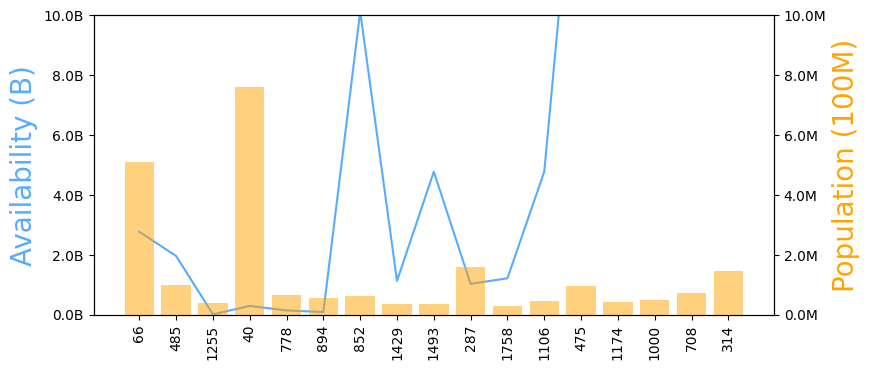

/tmp/ipykernel_3175/1886685843.py:135: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  texts.append(ax.text(target_lons[i], target_lats[i], str(int(nums[txt])), fontsize=12, ha='right'))
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


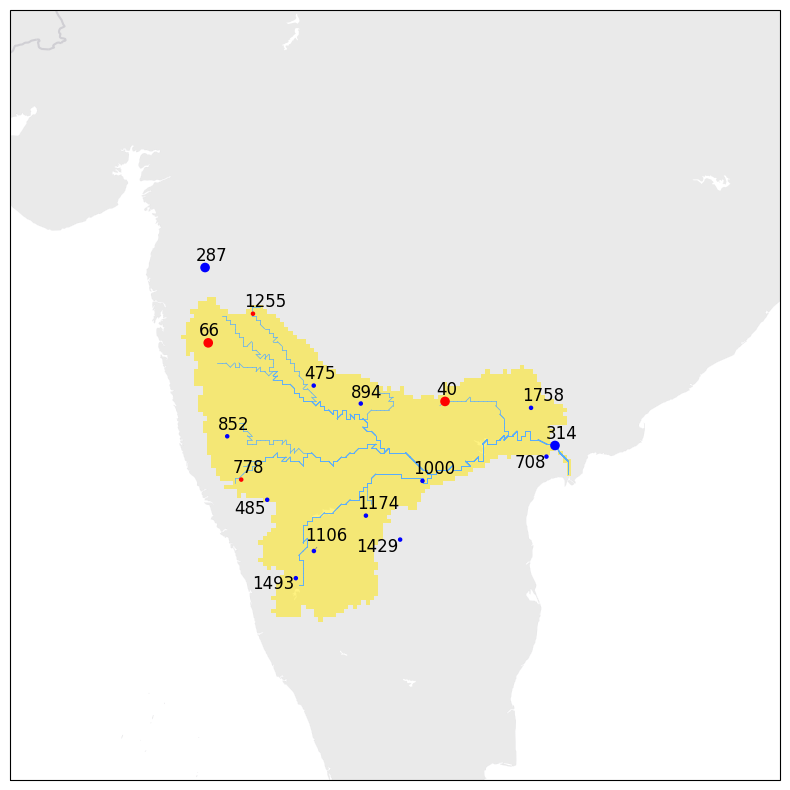

In [13]:
#############################################################
# it took 1min & 1min
#############################################################
bar_line(uid_str, riv_num)

left = 70
right = 85
bottom = 10
top = 25
main_plot(left, right, bottom, top, riv_num=riv_num, uid_str=uid_str)

In [38]:
def grid_to_latlon(row, col, extent):
    delta = 360/4320
    x_left, y_top = extent[0], extent[3]
    lon = x_left + (col+0.5) * delta
    lat = y_top - (row+0.5) * delta
    return lon, lat
    
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    projection = ccrs.PlateCarree()
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def toy():
    #
    msk_dir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/vld_cty_'
    basin_cities_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/riv_num_/basin_to_cities.json'
    with open(basin_cities_path, 'r') as json_file:
        new_basin_to_cities = json.load(json_file)
    #
    key_index = 64
    left = 73
    right = 82
    bottom = 12
    top = 21
    #
    resolution=12
    nx, ny = (right - left)*resolution, (top - bottom)*resolution
    rgnshape = (ny, nx)
    img_extent = (left, right, bottom, top)
    extent = (-180, 180, -90, 90)
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    
    ###########################################################################################
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # riv
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
    rivnum_masked = np.ma.masked_where(rivnum_cropped != riv_num, rivnum_cropped)
    
    # discharge
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000

    # lonlat
    lonlat_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat.npy'
    citylonlat = np.load(lonlat_path)

    nums = citylonlat[:, 0]
    lons = citylonlat[:, 1]
    lats = citylonlat[:, 2]

    # sort
    edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str=uid_str, riv_num=riv_num)
    sorted_order = topological_sort(edges)
    sorted_index = []
    for cnm in sorted_order:
        idx = np.where(np.array(nums) == cnm)[0]
        sorted_index.append(idx)

    target_lons = lons[sorted_index]
    target_lats = lats[sorted_index]
    
    # rivnxl
    path_dict = get_rivpath(riv_num, sorted_order, upperindex, lowerindex, leftindex, rightindex)

    # population
    updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon.txt'
    df_new = pd.read_csv(updown_path, delimiter='|', header=None)
    df_new.columns = df_new.iloc[0]
    df_new = df_new[1:].reset_index(drop=True)
    df_new = df_new.infer_objects()
    
    population = [df_new.loc[df_new['index'] == f'{city_num}', 'pop'].values[0] for city_num in sorted_order]
    population = [int(float(i)) for i in population]
    pop_size = [35 if i > 1e6 else 5 for i in population]

    mpcy_int = [df_new.loc[df_new['index'] == f'{city_num}', 'mpcy_int'].values[0] for city_num in sorted_order]
    target_mpcy = [int(float(i)) for i in mpcy_int]

    ###########################################################################################
    
    # cmap
    bounds = [0, 1000]
    cmap = mcolors.ListedColormap(['red', 'blue'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    rivnum_cmap = mcolors.ListedColormap(['#ffe500'])
    river_cmap = mcolors.ListedColormap(['#57acff'])

    # draw
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], projection)

    # rivnxl
    width = 1
    
    for city_num in sorted_order:
        path_coords = path_dict[city_num]
        
        #2つずつのペアに変換
        path_coords_lat = [coord[0] for coord in path_coords]
        path_coords_lon = [coord[1] for coord in path_coords]
        path_coords_pairs = list(zip(path_coords_lat, path_coords_lon))
        path_coords_grouped = [(path_coords_lat[i:i + 2], path_coords_lon[i:i + 2]) for i in range(len(path_coords) - 1)]
        
        for lat_coords, lon_coords in path_coords_grouped:
            # dischargeの取得
            discharge = rivout_cropped[lat_coords[0], lon_coords[0]]
            if discharge > 1e10:
                linewidth = 1.5
            else:
                linewidth = 0.5
            
            # lat_coordsとlon_coordsの変換
            lat_coords = [img_extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
            lon_coords = [(lon + (1/(width * 2)))*(1/12) + img_extent[0] for lon in lon_coords]
            
            # ax.plotを使ってプロット
            ax.plot(lon_coords, lat_coords, 
                    markersize=0, linewidth=linewidth, color='#57acff',
                    marker='o', linestyle='-', transform=projection, zorder=2
                   )

    # rivnum
    bg = ax.imshow(rivnum_masked, 
                   alpha=0.5, cmap=rivnum_cmap, transform=projection, extent=img_extent
                  )

    # lonlat
    img = ax.scatter(target_lons, target_lats, c=target_mpcy, s=pop_size,
                     cmap=cmap, norm=norm, transform=projection, zorder=3
                    )

    # city outer
    for city_num in city_list_removed:
        ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
        citymask = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
        citymask_cropped = citymask[upperindex:lowerindex, leftindex:rightindex]
        draw_mask_sotowaku(img_extent, citymask_cropped, ax=ax, sotowaku_color='black', linewidth=1)

    # intake or prf location
    prf_latlon = [grid_to_latlon(coord[0][0], coord[1][0], extent) for coord, _ in coords_a]
    for lon, lat in prf_latlon:
        ax.plot(lon, lat, marker='*', color='green', markersize=5, transform=ccrs.PlateCarree())

    # text
    texts = []
    for i, txt in enumerate(sorted_index):
        texts.append(ax.text(target_lons[i], target_lats[i], str(int(nums[txt])), fontsize=12, ha='right'))

    adjust_text(texts, only_move={'points': 'xy', 'text': 'xy'}, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))
    
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)
    
    plt.show()


/tmp/ipykernel_3175/1501808197.py:196: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  texts.append(ax.text(target_lons[i], target_lats[i], str(int(nums[txt])), fontsize=12, ha='right'))


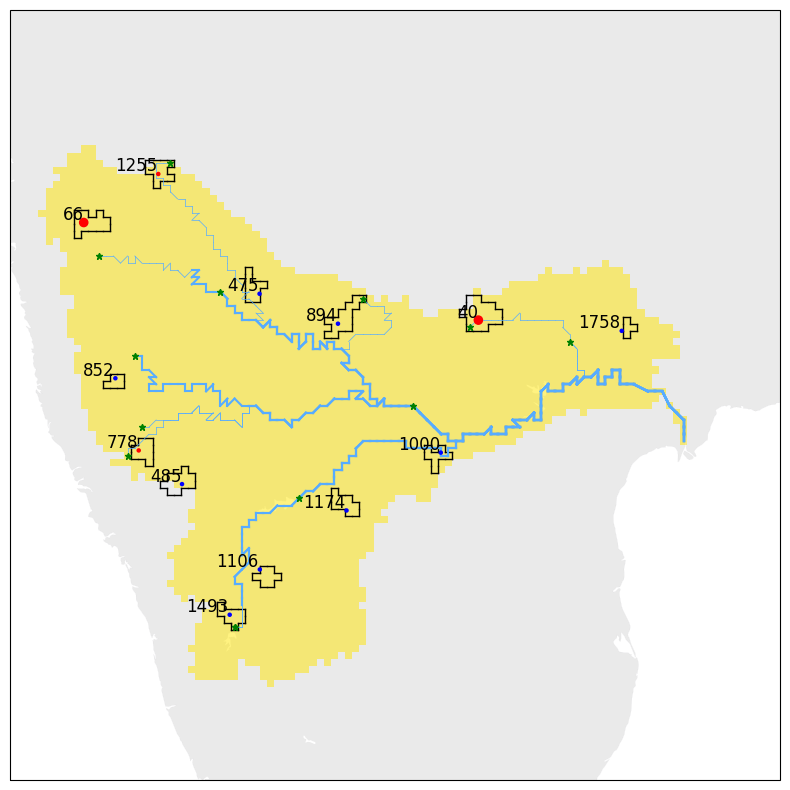

In [39]:
toy()

In [33]:
print(coords_a)
print(coords_a[0][0][1][0])

[[(array([872]), array([3100])), 40], [(array([862]), array([3048])), 66], [(array([851]), array([3049])), 287], [(array([881]), array([3125])), 314], [(array([867]), array([3065])), 475], [(array([886]), array([3054])), 485], [(array([880]), array([3123])), 708], [(array([890]), array([3052])), 778], [(array([876]), array([3053])), 852], [(array([868]), array([3085])), 894], [(array([883]), array([3092])), 1000], [(array([914]), array([3067])), 1106], [(array([896]), array([3076])), 1174], [(array([849]), array([3058])), 1255], [(array([895]), array([3084])), 1429], [(array([914]), array([3067])), 1493], [(array([874]), array([3114])), 1758]]
3100


In [112]:
from matplotlib.patches import FancyArrowPatch

def grid_to_latlon(row, col, extent):
    delta = 360/4320
    x_left, y_top = extent[0], extent[3]
    lon = x_left + (col+0.5) * delta
    lat = y_top - (row+0.5) * delta
    return lon, lat
    
def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    projection = ccrs.PlateCarree()
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

def toy2():
    #
    msk_dir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/vld_cty_'
    basin_cities_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/riv_num_/basin_to_cities.json'
    with open(basin_cities_path, 'r') as json_file:
        new_basin_to_cities = json.load(json_file)
    #
    key_index = 64
    left = 70
    right = 85
    bottom = 10
    top = 25
    #
    resolution=12
    nx, ny = (right - left)*resolution, (top - bottom)*resolution
    rgnshape = (ny, nx)
    img_extent = (left, right, bottom, top)
    extent = (-180, 180, -90, 90)
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    
    ###########################################################################################
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # riv
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
    rivnum_masked = np.ma.masked_where(rivnum_cropped != riv_num, rivnum_cropped)
    
    # discharge
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000

    # lonlat
    lonlat_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat.npy'
    citylonlat = np.load(lonlat_path)

    nums = citylonlat[:, 0]
    lons = citylonlat[:, 1]
    lats = citylonlat[:, 2]

    # sort
    edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str=uid_str, riv_num=riv_num)
    sorted_order = topological_sort(edges)
    print(sorted_order)
    
    sorted_index = []
    for cnm in sorted_order:
        idx = np.where(np.array(nums) == cnm)[0]
        sorted_index.append(idx)

    target_lons = lons[sorted_index]
    target_lats = lats[sorted_index]
    
    # rivnxl
    path_dict = get_rivpath(riv_num, sorted_order, upperindex, lowerindex, leftindex, rightindex)

    # population
    updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon.txt'
    df_new = pd.read_csv(updown_path, delimiter='|', header=None)
    df_new.columns = df_new.iloc[0]
    df_new = df_new[1:].reset_index(drop=True)
    df_new = df_new.infer_objects()
    
    population = [df_new.loc[df_new['index'] == f'{city_num}', 'pop'].values[0] for city_num in sorted_order]
    population = [int(float(i)) for i in population]
    pop_size = [35 if i > 1e6 else 5 for i in population]

    mpcy_int = [df_new.loc[df_new['index'] == f'{city_num}', 'mpcy_int'].values[0] for city_num in sorted_order]
    target_mpcy = [int(float(i)) for i in mpcy_int]
    cityname_list = [df_new.loc[df_new['index'] == f'{city_num}', 'cityname'].values[0] for city_num in sorted_order]
    
    ###########################################################################################
    # if there are prf out of uid_int => add pprf_dct as list
    # if abandon prf => add prf to sprf_dct
    # if abandon int(no int) => add None to int_dct

    pprf_dct = {}
    sprf_dct = {}
    ibt_dct = {}
    
    for city_num in sorted_order:
    
        # prf
        prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
        prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
        prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
        prf_cropped = prf[upperindex:lowerindex, leftindex:rightindex]
    
        # int
        int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
        intake_cropped = intake[upperindex:lowerindex, leftindex:rightindex]
        
        # 1. prfのみが対象流域内(uid)
        # 2. intのみが対象流域内(uid)
        # 3. prfとintどちらもが対象領域内(uid)
        uid_int = int(riv_num)
        pprf_coord = np.where((prf_cropped == 1) & (rivnum_cropped == uid_int))
        sprf_coord = np.where((prf_cropped == 1) & (rivnum_cropped != uid_int))
        int_coord = np.where((intake_cropped == 1) & (rivnum_cropped == uid_int))
    
        # separte single sprf and multiple sprf
        if sprf_coord[0].size == 0:
            sprf_coord = None
        else:
            sprf_coord = sprf_coord
    
        # int or prf selection
        if pprf_coord[0].size != 0 and int_coord[0].size != 0:
            prf_runout = rivout_cropped[pprf_coord][0] * 60 * 60 * 24 * 365 / (1000)
            int_runout = rivout_cropped[int_coord][0] * 60 * 60 * 24 * 365 / (1000)
            
            if prf_runout > int_runout:
                primary_coord = pprf_coord
                secondary_coord = sprf_coord
                ibt_coord     = None
            else:
                primary_coord = pprf_coord
                secondary_coord = sprf_coord
                ibt_coord = int_coord
                
        elif pprf_coord[0].size != 0 and int_coord[0].size == 0:
            primary_coord = pprf_coord
            secondary_coord = sprf_coord
            ibt_coord     = None
            
        elif pprf_coord[0].size == 0 and int_coord[0].size != 0:
            if len(sprf_coord[0]) == 1:
                primary_coord = sprf_coord
                secondary_coord = None
            else:
                primary_coord = (sprf_coord[0][0], sprf_coord[1][0])
                secondary_coord = (np.delete(sprf_coord[0], 0), np.delete(sprf_coord[1], 0))
            ibt_coord = int_coord
            
        else:
            primary_coord = None
            secondary_coord = None
            ibt_coord = None
            
        pprf_dct[city_num] = primary_coord
        sprf_dct[city_num] = secondary_coord
        ibt_dct[city_num] = ibt_coord
    
    ###########################################################################################
    
    # cmap
    bounds = [0, 1000]
    cmap = mcolors.ListedColormap(['red', 'blue'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    rivnum_cmap = mcolors.ListedColormap(['#ffe500'])
    river_cmap = mcolors.ListedColormap(['#57acff'])

    # draw
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], projection)

    # rivnxl
    width = 1
    
    for city_num in sorted_order:
        path_coords = path_dict[city_num]
        
        #2つずつのペアに変換
        path_coords_lat = [coord[0] for coord in path_coords]
        path_coords_lon = [coord[1] for coord in path_coords]
        path_coords_pairs = list(zip(path_coords_lat, path_coords_lon))
        path_coords_grouped = [(path_coords_lat[i:i + 2], path_coords_lon[i:i + 2]) for i in range(len(path_coords) - 1)]
        
        for lat_coords, lon_coords in path_coords_grouped:
            # dischargeの取得
            discharge = rivout_cropped[lat_coords[0], lon_coords[0]]
            if discharge > 1e10:
                linewidth = 1.5
            else:
                linewidth = 0.5
            
            # lat_coordsとlon_coordsの変換
            lat_coords = [img_extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
            lon_coords = [(lon + (1/(width * 2)))*(1/12) + img_extent[0] for lon in lon_coords]
            
            # ax.plotを使ってプロット
            ax.plot(lon_coords, lat_coords, 
                    markersize=0, linewidth=linewidth, color='#57acff',
                    marker='o', linestyle='-', transform=projection, zorder=2
                   )

    # rivnum
    bg = ax.imshow(rivnum_masked, 
                   alpha=0.5, cmap=rivnum_cmap, transform=projection, extent=img_extent
                  )

    # city outer
    for city_num in sorted_order:
        print(f'city_num: {city_num}')
        ctymsk_path = f'{msk_dir}/city_{city_num:08}.gl5'
        citymask = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
        citymask_cropped = citymask[upperindex:lowerindex, leftindex:rightindex]
        draw_mask_sotowaku(img_extent, citymask_cropped, ax=ax, sotowaku_color='white', linewidth=2)
        
    # prf
    pprf_latlon = [grid_to_latlon(coord[0][0], coord[1][0], img_extent) for _, coord in pprf_dct.items()]
    pprf_lon, pprf_lat = zip(*pprf_latlon)
    ax.scatter(pprf_lon, pprf_lat, c=target_mpcy, s=pop_size, 
            cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), zorder=3)

    # int
    int_latlon = [
        grid_to_latlon(coord[0][0], coord[1][0], img_extent) if coord is not None else (None, None) 
        for n, coord in ibt_dct.items()
    ]
    for lon, lat in int_latlon:
        if lon is not None and lat is not None:
            ax.plot(lon, lat, marker='^', color='green', markersize=5, 
                    transform=ccrs.PlateCarree(), zorder=2)

    # arrow
    for int_latlon, prf_latlon in zip(int_latlon, pprf_latlon):
        if int_latlon[0] is not None and int_latlon[1] is not None:
            start_lon, start_lat = int_latlon[0], int_latlon[1]
            end_lon, end_lat = prf_latlon[0], prf_latlon[1]
            arrow = FancyArrowPatch((start_lon, start_lat), (end_lon, end_lat),
                                    color='green', linewidth=0.7, arrowstyle='-', mutation_scale=15, zorder=1)
            ax.add_patch(arrow)

    # text
    texts = []
    for i, txt in enumerate(cityname_list):
        texts.append(ax.text(pprf_lon[i], pprf_lat[i], txt, fontsize=12, ha='right'))

    adjust_text(texts, only_move={'points': 'xy', 'text': 'xy'}, arrowprops=dict(arrowstyle='-', color='grey', lw=0.5))
    
    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.1,edgecolor='#d0cfd4')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)
    
    plt.show()

[66, 485, 1255, 40, 778, 894, 852, 1493, 475, 1758, 1106, 1000, 1174]
city_num: 66
city_num: 485
city_num: 1255
city_num: 40
city_num: 778
city_num: 894
city_num: 852
city_num: 1493
city_num: 475
city_num: 1758
city_num: 1106
city_num: 1000
city_num: 1174


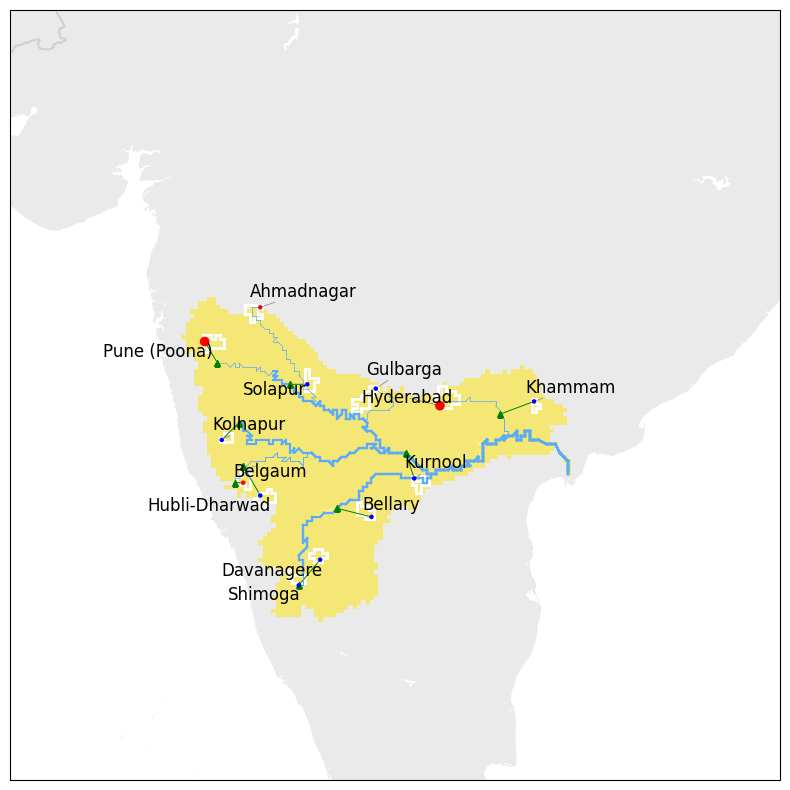

In [113]:
# prfの位置をscatterする (abandanしているものに関しても検討する)
    # できれば複数のprfについて触れたい
    # ほかの流域は紫で示したい

toy2()

In [82]:
##########################################################################################3
# prf coord
# int coord
# experiment
##########################################################################################3
#
key_index = 64
left = 73
right = 82
bottom = 12
top = 21
#
resolution=12
nx, ny = (right - left)*resolution, (top - bottom)*resolution
rgnshape = (ny, nx)
img_extent = (left, right, bottom, top)
extent = (-180, 180, -90, 90)
#
upperindex = (90-top)*resolution
lowerindex = (90-bottom)*resolution
leftindex = (180+left)*resolution
rightindex = (180+right)*resolution
#

###########################################################################################
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

# riv
rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
rivnum_masked = np.ma.masked_where(rivnum_cropped != riv_num, rivnum_cropped)

# discharge
rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000

# lonlat
lonlat_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat.npy'
citylonlat = np.load(lonlat_path)

nums = citylonlat[:, 0]
lons = citylonlat[:, 1]
lats = citylonlat[:, 2]

# sort
edges, riv_path_array, coords_a, city_list_removed = updown(new_basin_to_cities, uid_str=uid_str, riv_num=riv_num)
sorted_order = topological_sort(edges)
sorted_index = []

for cnm in sorted_order:
    idx = np.where(np.array(nums) == cnm)[0]
    sorted_index.append(idx)

target_lons = lons[sorted_index]
target_lats = lats[sorted_index]

# rivnxl
path_dict = get_rivpath(riv_num, sorted_order, upperindex, lowerindex, leftindex, rightindex)

# population
updown_path = f'{h08dir}/wsi/dat/availablewater/updown_availability_100km_abandon.txt'
df_new = pd.read_csv(updown_path, delimiter='|', header=None)
df_new.columns = df_new.iloc[0]
df_new = df_new[1:].reset_index(drop=True)
df_new = df_new.infer_objects()

population = [df_new.loc[df_new['index'] == f'{city_num}', 'pop'].values[0] for city_num in sorted_order]
population = [int(float(i)) for i in population]
pop_size = [35 if i > 1e6 else 5 for i in population]

mpcy_int = [df_new.loc[df_new['index'] == f'{city_num}', 'mpcy_int'].values[0] for city_num in sorted_order]
target_mpcy = [int(float(i)) for i in mpcy_int]
cityname_list = [df_new.loc[df_new['index'] == f'{city_num}', 'cityname'].values[0] for city_num in sorted_order]

#########################################################################################################################

pprf_dct = {}
sprf_dct = {}
ibt_dct = {}

print(sorted_order)

for city_num in sorted_order:

    # prf
    prf_dir = f'{h08dir}/global_city/dat/cty_prf_'
    prf_path = f'{prf_dir}/vld_cty_/city_{city_num:08}.gl5'
    prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
    prf_cropped = prf[upperindex:lowerindex, leftindex:rightindex]

    # int
    int_dir = f'{h08dir}/global_city/dat/cty_int_/{distance}km_samebasin'
    int_path = f'{int_dir}/city_{city_num:08}.gl5'
    intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
    intake_cropped = intake[upperindex:lowerindex, leftindex:rightindex]
    
    # 1. prfのみが対象流域内(uid)
    # 2. intのみが対象流域内(uid)
    # 3. prfとintどちらもが対象領域内(uid)
    uid_int = int(riv_num)
    pprf_coord = np.where((prf_cropped == 1) & (rivnum_cropped == uid_int))
    sprf_coord = np.where((prf_cropped == 1) & (rivnum_cropped != uid_int))
    int_coord = np.where((intake_cropped == 1) & (rivnum_cropped == uid_int))
    #print('-----------------------------------------')
    #print(f'pprf_coord: {pprf_coord}')
    #print(f'sprf_coord: {sprf_coord}')
    #print(f'int_coord: {int_coord}')

    # separte single sprf and multiple sprf
    if sprf_coord[0].size == 0:
        sprf_coord = None
    else:
        sprf_coord = sprf_coord

    # int or prf selection
    if pprf_coord[0].size != 0 and int_coord[0].size != 0:
        prf_runout = rivout_cropped[pprf_coord][0] * 60 * 60 * 24 * 365 / (1000)
        int_runout = rivout_cropped[int_coord][0] * 60 * 60 * 24 * 365 / (1000)
        
        if prf_runout > int_runout:
            primary_coord = pprf_coord
            secondary_coord = sprf_coord
            ibt_coord     = None
        else:
            primary_coord = pprf_coord
            secondary_coord = sprf_coord
            ibt_coord = int_coord
            
    elif pprf_coord[0].size != 0 and int_coord[0].size == 0:
        primary_coord = pprf_coord
        secondary_coord = sprf_coord
        ibt_coord     = None
        
    elif pprf_coord[0].size == 0 and int_coord[0].size != 0:
        if len(sprf_coord[0]) == 1:
            primary_coord = sprf_coord
            secondary_coord = None
        else:
            primary_coord = (sprf_coord[0][0], sprf_coord[1][0])
            secondary_coord = (np.delete(sprf_coord[0], 0), np.delete(sprf_coord[1], 0))
        ibt_coord = int_coord
        
    else:
        primary_coord = None
        secondary_coord = None
        ibt_coord = None
        
    print('-----------------------------------------')
    print(f'city_num: {city_num}')
    print(f'primary_coord: {primary_coord}')
    print(f'secondary_coord: {secondary_coord}')
    print(f'ibt_coord: {ibt_coord}')
        
    pprf_dct[city_num] = primary_coord
    sprf_dct[city_num] = secondary_coord
    ibt_dct[city_num] = ibt_coord

[66, 485, 1255, 40, 778, 894, 852, 1429, 1493, 287, 1758, 1106, 475, 1174, 1000, 708, 314]
-----------------------------------------
city_num: 66
primary_coord: (array([29]), array([9]))
secondary_coord: None
ibt_coord: (array([34]), array([12]))
-----------------------------------------
city_num: 485
primary_coord: (array([65]), array([22]))
secondary_coord: (array([66, 67]), array([22, 22]))
ibt_coord: (array([58]), array([18]))
-----------------------------------------
city_num: 1255
primary_coord: (array([21]), array([22]))
secondary_coord: None
ibt_coord: None
-----------------------------------------
city_num: 40
primary_coord: (array([44]), array([64]))
secondary_coord: None
ibt_coord: None
-----------------------------------------
city_num: 778
primary_coord: (array([62]), array([18]))
secondary_coord: None
ibt_coord: (array([62]), array([16]))
-----------------------------------------
city_num: 894
primary_coord: (array([40]), array([49]))
secondary_coord: None
ibt_coord: None

In [85]:
for key, value in pprf_dct.items():
    print(key, value)

66 (array([29]), array([9]))
485 (array([65]), array([22]))
1255 (array([21]), array([22]))
40 (array([44]), array([64]))
778 (array([62]), array([18]))
894 (array([40]), array([49]))
852 (array([52]), array([13]))
1429 (array([76]), array([54]))
1493 (array([86]), array([31]))
287 (array([13]), array([9]))
1758 (array([43]), array([86]))
1106 (array([80]), array([36]))
475 (array([39]), array([33]))
1174 (array([70]), array([48]))
1000 (array([61]), array([58]))
708 (array([56]), array([89]))
314 (array([54]), array([91]))


In [102]:
for _, coord in pprf_dct.items():
    print(coord)
    print(coord[0][0], coord[1][0])
pprf_latlon = [grid_to_latlon(coord[0][0], coord[1][0], img_extent) for _, coord in pprf_dct.items()]
pprf_lon, pprf_lat = zip(*pprf_latlon)
print(pprf_lon, pprf_lat)

(array([29]), array([9]))
29 9
(array([65]), array([22]))
65 22
(array([21]), array([22]))
21 22
(array([44]), array([64]))
44 64
(array([62]), array([18]))
62 18
(array([40]), array([49]))
40 49
(array([52]), array([13]))
52 13
(array([76]), array([54]))
76 54
(array([86]), array([31]))
86 31
(array([13]), array([9]))
13 9
(array([43]), array([86]))
43 86
(array([80]), array([36]))
80 36
(array([39]), array([33]))
39 33
(array([70]), array([48]))
70 48
(array([61]), array([58]))
61 58
(array([56]), array([89]))
56 89
(array([54]), array([91]))
54 91
(73.79166666666667, 74.875, 74.875, 78.375, 74.54166666666667, 77.125, 74.125, 77.54166666666667, 75.625, 73.79166666666667, 80.20833333333333, 76.04166666666667, 75.79166666666667, 77.04166666666667, 77.875, 80.45833333333333, 80.625) (18.541666666666668, 15.541666666666668, 19.208333333333332, 17.291666666666668, 15.791666666666668, 17.625, 16.625, 14.625, 13.791666666666668, 19.875, 17.375, 14.291666666666668, 17.708333333333332, 15.125

In [105]:
int_latlon = [
    grid_to_latlon(coord[0][0], coord[1][0], img_extent) if coord is not None else (None, None) 
    for n, coord in ibt_dct.items()
]
for int_latlon, prf_latlon in zip(int_latlon, pprf_latlon):
    if int_latlon[0] is not None and int_latlon[1] is not None:
        start_lon, start_lat = int_latlon[0], int_latlon[1]
        end_lon, end_lat = prf_latlon[0], prf_latlon[1]
        print(start_lon, start_lat, end_lon, end_lat)

74.04166666666667 18.125 73.79166666666667 18.541666666666668
74.54166666666667 16.125 74.875 15.541666666666668
74.375 15.791666666666668 74.54166666666667 15.791666666666668
74.45833333333333 16.958333333333336 74.125 16.625
77.04166666666667 15.375 77.54166666666667 14.625
74.125 19.041666666666668 73.79166666666667 19.875
79.54166666666667 17.125 80.20833333333333 17.375
75.625 13.791666666666668 76.04166666666667 14.291666666666668
75.45833333333333 17.708333333333332 75.79166666666667 17.708333333333332
76.375 15.291666666666668 77.04166666666667 15.125
77.70833333333333 16.375 77.875 15.875
80.29166666666667 16.625 80.45833333333333 16.291666666666668
80.45833333333333 16.541666666666668 80.625 16.458333333333336
